

# Reporte de problemas fitosanitarios en plantaciones de agave
--------------------

## Equipo 36

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

## Avance 4: Modelos alternativos 

Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

# Introducción

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuáles fueron `RandomForestRegressor` y `XGBoost`. De éstos 2 modelos, el que mejor rendimiento tuvo fue el `RandomForestRegressor`, con un R^2 de `0.53`.

Por lo anterior, estaremos explorando al menos 6 modelos distintos y cambiando nuestro Feature Engineering para lograr un mejor resultado en la predicción de nuestro R^2 o `accuracy` score si decidimos trabajar sobre la variable `severity_encode`. Agregado a esto, haremos una etapa de feature engineering la cual incluirá:

- La precipitación registrada por la estación climatológica más cercana a la ubicación de la trampa muestreada durante el mismo mes en que se tomó la muestra.
- La temperatura media, maxima y mínima de la estación climatológica más cercana a la ubicación de la trampa muestreada en el mismo año y mes.

Esta información está disponible desde `https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias`, y es posible descargar esta información por medio de los scripts `smn_precipitation_downloader.py` y `smn_temp_downloader.py`, y generar los archivos CSV por medio de los scripts `smn_precipitation_builder.py` y `smn_temp_builder.py`.

# Objetivo

Con lo anterior, es importante tomar en cuenta que nuestro objetivo para esta entrega se basa en predecir el nivel de infestación con la que se catalogan los focos de infestación (seguro, leve, moderado y severo). 

Ahora, como sabemos, contamos con un dataset desbalanceado:

- El 62% de las muestras históricas son leves.
- El 35% de los registros indican un nivel seguro de severidad.
- El 1.1% se considera como moderado.
- El 0.15% de la muestra es severa.

Por lo anterior, usar una métrica como `accuracy` no es buena idea, ya que nuestros modelos podrían llegar a tener esta métrica elevado haciendo uso de una clasificación leve o segura. Por lo tanto, las métricas que debemos tomar en cuenta son las siguientes:

- `Recall`: requerimos detectar correctamente los casos positivos de la clase objetivo.
- `F1`: esta métrica nos da una idea de qué tan balanceado es nuestro modelo para todas las clases en general.
- `Precision`: nos ayudará a controlar los falsos positivos una vez logremos que nuestro `Recall` mejore.
- `AUC`: para analizar los resultados gráficamente y seleccionar el mejor modelo.

# Librerías

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import BallTree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np

# Carga del dataset

En esta sección cargaremos el dataset `Baseline.xlsx`, el cual contiene los `text_features` para hacer el fine-tuning de nuestro LLM.

Por lo tanto, no haremos uso de los `text_features` debido a que éstos son la combinación de varios features previos.

In [2]:
df = pd.read_excel('baseline.xlsx')
df.dtypes

Unnamed: 0                              int64
tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
square_area                           float64
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                         

In [3]:
# Eliminamos las columnas irrelevantes para nuestros modelos.
df.drop(labels=['Unnamed: 0', 'square_area', 'text_feature_location',  'text_feature_risk', 'text_feature_capture', 'text_feature_plantation', 'text_feature_all_things'], axis=1, inplace=True)
df.dtypes

tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                             float64
critical_season                         int64
severity_encoded                  

# Feature engineering de nuevo...

## Carga de precipitación y temperatura histórica

Con base en los resultados obtenidos en nuestro Baseline, vemos con buenos ojos pensar de nuevo los features que debemos tomar en cuenta para predecir la severidad de un posible foco de infección.

Para esto, hemos descargado y procesado la información disponible de parte del Gobierno de México para tomar en cuenta:

- La precipitación en mm.
- La temperatura media, máxima y mínima 

Y haremos uso de la información proporcionada por la estación más cercana a cada muestra de nuestro dataset.

In [4]:
precipitation_df = pd.read_csv('precipitation_per_area_historical.csv')
avg_temp_df      = pd.read_csv('TMed_per_area_historical.csv')
max_temp_df      = pd.read_csv('TMax_per_area_historical.csv')
min_temp_df      = pd.read_csv('TMin_per_area_historical.csv')

print(f'El dataset de precipitacion tiene estas columnas: {precipitation_df.columns.tolist()}')
print(f'El dataset de avg_temp tiene estas columnas: {avg_temp_df.columns}')
print(f'El dataset de max_temp tiene estas columnas: {max_temp_df.columns}')
print(f'El dataset de min_temp tiene estas columnas: {min_temp_df.columns}')

El dataset de precipitacion tiene estas columnas: ['lon', 'lat', 'state', 'cve_sih', 'name', 'precipitation(mm)', 'year-month']
El dataset de avg_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMed', 'year-month'], dtype='object')
El dataset de max_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMax', 'year-month'], dtype='object')
El dataset de min_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMin', 'year-month'], dtype='object')


In [5]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158067.0,1.717909e+08,9.853862e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158067.0,5.697327e+07,3.079344e+08,147.0,2345.0,18794167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [6]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163149.0,-101.184182,5.850756,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163149.0,22.092611,4.143454,-99.90,19.12,20.8,25.03,32.70
TMed,163149.0,22.292233,5.657826,-99.90,18.10,22.3,27.00,41.80


In [7]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163237.0,-101.183637,5.850671,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163237.0,22.092476,4.143737,-99.90,19.12,20.8,25.03,32.70
TMax,163237.0,29.519894,5.428911,-99.90,25.60,29.7,33.60,51.10


In [8]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163264.0,-101.182702,5.850383,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163264.0,22.091303,4.143190,-99.90,19.12,20.75,25.03,32.70
TMin,163264.0,15.092148,6.768767,-99.90,10.10,15.00,20.80,38.00


Como notamos que la información de temperatura contiene registros con valores negativos de -99.90 grados de temperatura, y como sabemos que esto no pudo pasar en alguno de los estados muestreados, procedemos a eliminar estos registros que seguramente son resultado de una mala muestra.

In [9]:
precipitation_df = precipitation_df[ precipitation_df['precipitation(mm)'] >= 0 ]
max_temp_df      = max_temp_df[ max_temp_df['TMax'] >= -99 ]
avg_temp_df      = avg_temp_df[ avg_temp_df['TMed'] >= -99 ]
min_temp_df      = min_temp_df[ min_temp_df['TMin'] >= -99 ]

In [10]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158020.0,1.718176e+08,9.855313e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158020.0,5.698401e+07,3.079796e+08,147.0,2345.0,18789167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [11]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163144.0,-101.184222,5.850841,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163144.0,22.096349,4.088107,14.63,19.12,20.8,25.03,32.70
TMed,163144.0,22.295978,5.617327,-0.80,18.10,22.3,27.00,41.80


In [12]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163232.0,-101.183677,5.850757,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163232.0,22.096213,4.088424,14.63,19.12,20.8,25.03,32.70
TMax,163232.0,29.523859,5.381533,3.20,25.60,29.7,33.60,51.10


In [13]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163259.0,-101.182741,5.850468,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163259.0,22.095040,4.087879,14.63,19.12,20.75,25.03,32.70
TMin,163259.0,15.095670,6.738888,-13.30,10.10,15.00,20.80,38.00


Con lo anterior, confirmamos que nuestros datasets de precipitación y temperaturas son correctos.

#### Información sobre el clima

In [14]:
# Year-Month es una columna planeada para hacer el match con las estaciones más cercanas a cada trampa registrada
df = df.rename(columns={'year_month': 'year-month'})

In [15]:
# Esta función nos ayudará a:
# - Filtrar por año-mes las estaciones disponibles.
# - Identificar la estación más cercana al usar la formular de Haversine (esta toma en cuenta la curvatura de la Tierra)
# - Nuevamente usamos BallTree para hacer uso de funciones vectorizadas y no calcular la distancia por medio de ciclos


def find_weather_station(df_samples, weather_df, value_col):
    
    results = []
    
    for ym, group in df_samples.groupby('year-month'):
        
        subset = weather_df[(weather_df['year-month'] == ym) & (weather_df[value_col].notna())]
        
        if subset.empty:
            results.extend([np.nan] * len(group))
            continue
        
        # Usamos BallTree para calcular la distancia, ya que este modelo está vectorizado
        tree = BallTree(np.radians(subset[['lat', 'lon']].values), metric='haversine')
        
        # Obtenemos la distancia y elemento mas cercano
        distances, indices = tree.query(np.radians(group[['lat', 'lon']].values), k=1)
        nearest_values = subset.iloc[indices.flatten()][value_col].values
        results.extend(nearest_values)

    return np.array(results)

In [16]:
# Aquí podemos definir de cuando a cuando filtrar nuestro DataSet para hacer experimentos rapidos
# con cada tipo de modelo.

df_filtered = df[(df['sampling_date'].dt.year >= 2014) & 
                 (df['sampling_date'].dt.year <= 2025)]

print(f"Original: {len(df)} | Filtrado: {len(df_filtered)}")

Original: 827856 | Filtrado: 827856


In [17]:
# Agregamos las columnas de temperatura y precipitacion a nuestro dataset. La idea principal es que 
# conocemos esto porque la SMN mantiene en su sitio web los valores históricos de precipitacion,
# temperatura maxima, minima y promedio por estacion meteorologica, y como conocemos
# la ubicacion de las estaciones y trampas, podemos ver cual es la estacion mas cercana y adjuntar esa
# data a nuestro dataset.

df_filtered['precipitation'] = find_weather_station(df_filtered, precipitation_df, 'precipitation(mm)')
df_filtered['avg_temp'] = find_weather_station(df_filtered, avg_temp_df, 'TMed')
df_filtered['max_temp'] = find_weather_station(df_filtered, max_temp_df, 'TMax')
df_filtered['min_temp'] = find_weather_station(df_filtered, min_temp_df, 'TMin')


# Debemos descomenttar la siguiente línea de código si queremos generar un archivo de Excel que incluya la informacion del clima.
# df_filtered.to_excel('data_with_weather_information.xlsx', index= False )

# Esta línea de código permite cargar la información lista con los aspectos de precipitacion y temperatura
#df_filtered = pd.read_excel('data_with_weather_information.xlsx')

In [20]:
# Confirmamos que tenemos un dataset desbalanceado

print("Porcentajes de presencia de severity_encoded:")
df_filtered['severity_encoded'].value_counts() / len(df_filtered) * 100

Porcentajes de presencia de severity_encoded:


severity_encoded
1    62.650872
0    35.207210
2     1.990201
3     0.151717
Name: count, dtype: float64

### Creamos `rolling_features`

In [ ]:
# df_filtered = df_filtered.sort_values(['tramp_id', 'sampling_date'])

# rolling_features = {
#     'precipitation': ['sum', 'mean'],
#     'avg_temp': ['mean', 'std'],
#     'max_temp': ['max'],
#     'min_temp': ['min'],
#     'distance_to_nearest_hotspot': ['mean', 'std'],
#     'hotspots_within_5km': ['mean', 'sum'],
#     'square_area_imputed': ['mean'],
# }

# window_sizes = [15, 30, 60, 120, 180]

# for window in window_sizes:
#     rolled = (
#         df_filtered
#         .groupby('tramp_id', group_keys=False)
#         .rolling(window=window, min_periods=1)
#         .agg(rolling_features)
#         .reset_index(level=0, drop=True)
#     )

    
#     if isinstance(rolled.columns, pd.MultiIndex):
#         rolled.columns = [f"{col}_roll{window}_{func}" for col, func in rolled.columns]
#     else:
#         rolled.columns = [f"{col}_roll{window}" for col in rolled.columns]

#     df_filtered = pd.concat([df_filtered, rolled], axis=1)

# df_filtered = (
#     df_filtered
#     .groupby('tramp_id', group_keys=False)
#     .apply(lambda g: g.ffill().bfill())
#     .reset_index(drop=True)
# )


In [ ]:
# df_filtered = df_filtered.sort_values(['tramp_id', 'sampling_date'])

# rolling_features = {
#     'precipitation': ['sum', 'mean'],
#     'avg_temp': ['mean', 'std'],
#     'max_temp': ['max'],
#     'min_temp': ['min'],
#     'distance_to_nearest_hotspot': ['mean', 'std'],
#     'hotspots_within_5km': ['mean', 'sum'],
#     'square_area_imputed': ['mean'],
# }

# window_sizes = [15, 30, 60, 120, 180]

# for window in window_sizes:
#     rolled = (
#         df_filtered
#         .groupby('tramp_id', group_keys=False)
#         .rolling(window=window, min_periods=1)
#         .agg(rolling_features)
#     )

#     if isinstance(rolled.columns, pd.MultiIndex):
#         rolled.columns = [f"{col}_roll{window}_{func}" for col, func in rolled.columns]
#     else:
#         rolled.columns = [f"{col}_roll{window}" for col in rolled.columns]

#     df_filtered = pd.concat([df_filtered, rolled.reset_index(level=0, drop=True)], axis=1)
    
# df_filtered = pd.concat(
#     [df_filtered, rolled.reset_index(level=0, drop=True)], axis=1
# ).fillna(method='bfill')


### Lagging features

In [ ]:
# import pandas as pd

# df_filtered = df_filtered.sort_values(['tramp_id', 'sampling_date'])
# grouped = df_filtered.groupby('tramp_id', group_keys=False)

# lag_features = [
#     'precipitation', 'avg_temp', 'max_temp', 'min_temp',
#     'distance_to_nearest_hotspot', 'hotspots_within_5km',
#     'square_area_imputed', 'plantation_age', 'critical_season'
# ]

# lags = [1, 3, 7]

# for lag in lags:
#     shifted = grouped[lag_features].shift(lag)
#     shifted.columns = [f"{col}_lag{lag}" for col in lag_features]
#     df_filtered = pd.concat([df_filtered, shifted], axis=1)


In [19]:
df_filtered.isna().sum()

tramp_id                       0
sampling_date                  0
lat                            0
lon                            0
municipality                   0
plantation_age                 0
capture_count                  0
state                          0
square_area_imputed            0
month                          0
year                           0
year-month                     0
day_of_year_sin                0
day_of_year_cos                0
day_of_week_sin                0
day_of_week_cos                0
week_of_year_sin               0
week_of_year_cos               0
month_sin                      0
month_cos                      0
critical_season                0
severity_encoded               0
distance_to_nearest_hotspot    0
hotspots_within_5km            0
precipitation                  0
avg_temp                       0
max_temp                       0
min_temp                       0
dtype: int64

# RandomForest

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuales fueron `RandomForestRegressor` y `XGBoost`. Con esto, `RandomForestRegressor` tuvo mejores resultados, por lo que el primero modelo a implementar con la nueva información del clima será este mismo.

In [47]:
rf_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    rf_df[col] = le.fit_transform(rf_df[col])

train_mask = rf_df['sampling_date'].dt.year < 2025
test_mask  = rf_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date',
]

features = [col for col in rf_df.columns if col not in exclude_cols]

X_train, y_train = rf_df.loc[train_mask, features], rf_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = rf_df.loc[test_mask,  features], rf_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Resultados para RandomForest:\n")
print(classification_report(y_test, y_pred))

Resultados para RandomForest:

              precision    recall  f1-score   support

           0       0.29      0.17      0.21     24445
           1       0.76      0.87      0.82     82928
           2       0.16      0.00      0.00      2544
           3       0.35      0.96      0.52       110

    accuracy                           0.70    110027
   macro avg       0.39      0.50      0.39    110027
weighted avg       0.64      0.70      0.66    110027



In [48]:
y_pred_proba_rf  = rf_model.predict_proba(X_test)

1 minuto y 15 segundos de entrenamiento

# Con `XGBoost`

In [49]:
class_counts = y_train.value_counts().sort_index()
num_classes = len(class_counts)
total = len(y_train)
class_weights = {i: total / (num_classes * count) for i, count in class_counts.items()}

weights = y_train.map(class_weights)

xgb_model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=10,
    learning_rate=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train, sample_weight=weights)

y_pred = xgb_model.predict(X_test)

print("Resultados para XGBoost (version GPU):")
print(classification_report(y_test, y_pred))

Resultados para XGBoost (version GPU):
              precision    recall  f1-score   support

           0       0.25      0.36      0.30     24445
           1       0.77      0.65      0.70     82928
           2       0.12      0.24      0.16      2544
           3       0.32      0.93      0.48       110

    accuracy                           0.57    110027
   macro avg       0.37      0.54      0.41    110027
weighted avg       0.64      0.57      0.60    110027



30 segundos de entrenamiento

# `DecisionTree`

In [51]:
dt_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    dt_df[col] = le.fit_transform(dt_df[col])

train_mask = dt_df['sampling_date'].dt.year < 2025
test_mask  = dt_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date',
    #'hotspots_within_5km',
    #'distance_to_nearest_hotspot'
]

features = [col for col in dt_df.columns if col not in exclude_cols]

X_train, y_train = dt_df.loc[train_mask, features], dt_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = dt_df.loc[test_mask,  features], dt_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

dt = DecisionTreeClassifier(
    criterion= 'entropy',        
    max_depth=10,          
    min_samples_split=4,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    max_features= 'log2'
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Resultados:")
print(classification_report(y_test, y_pred, digits=3))

Resultados:
              precision    recall  f1-score   support

           0      0.274     0.212     0.239     24445
           1      0.762     0.727     0.744     82928
           2      0.052     0.238     0.085      2544
           3      0.360     0.982     0.527       110

    accuracy                          0.602    110027
   macro avg      0.362     0.540     0.399    110027
weighted avg      0.637     0.602     0.617    110027



In [52]:
y_pred_proba_dt  = dt.predict_proba(X_test)

2 segundos de entrenamiento

# Perceptrón (MLP)

Para el modelo de MLP, cambiaremos un poco la estrategia:

- Codificaremos los estados con OneHot encoding
- Configuraremos distintos pesos para las distintas clases objetivo (0, 1, 2 y 3), de forma que la red neuronal entienda que confundirse en predecir las clases minoritarias es peor que confundirse en las clases mayoritarias. 

In [36]:
split_date = pd.Timestamp('2025-01-01')

train_df = df_filtered[df_filtered['sampling_date'] < split_date].copy()
test_df  = df_filtered[df_filtered['sampling_date'] >= split_date].copy()

X = df_filtered.drop(columns=['severity_encoded', 'sampling_date', 'tramp_id', 'year-month', 'capture_count'])
y = df_filtered['severity_encoded']


le = LabelEncoder()
X['municipality_encoded'] = le.fit_transform(X['municipality'].astype(str))

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
state_encoded = ohe.fit_transform(X[['state']])

state_encoded_df = pd.DataFrame(
    state_encoded,
    columns=ohe.get_feature_names_out(['state']),
    index=X.index
)

X = X.drop(['state', 'municipality'], axis=1)

X_encoded = pd.concat([X, state_encoded_df], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 16),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    alpha=0.0001,
    batch_size=128,
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=50,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred = mlp.predict(X_valid_scaled)



Iteration 1, loss = 1.14377489
Validation score: 0.479797
Iteration 2, loss = 1.03625383
Validation score: 0.505559
Iteration 3, loss = 1.00030882
Validation score: 0.520064
Iteration 4, loss = 0.97988969
Validation score: 0.519618
Iteration 5, loss = 0.96195570
Validation score: 0.551040
Iteration 6, loss = 0.94643087
Validation score: 0.549993
Iteration 7, loss = 0.93800103
Validation score: 0.551638
Iteration 8, loss = 0.92893720
Validation score: 0.556644
Iteration 9, loss = 0.91978860
Validation score: 0.562284
Iteration 10, loss = 0.91366236
Validation score: 0.547150
Iteration 11, loss = 0.90648089
Validation score: 0.559363
Iteration 12, loss = 0.90173161
Validation score: 0.570279
Iteration 13, loss = 0.89714929
Validation score: 0.564680
Iteration 14, loss = 0.89253236
Validation score: 0.556815
Iteration 15, loss = 0.88740684
Validation score: 0.566221
Iteration 16, loss = 0.88545066
Validation score: 0.555827
Iteration 17, loss = 0.88262988
Validation score: 0.577894
Iterat

d:\Python_Envs\torch311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Resultados para MLP:

              precision    recall  f1-score   support

           0       0.64      0.68      0.66     58293
           1       0.80      0.51      0.62    103733
           2       0.06      0.62      0.11      3295
           3       0.03      0.65      0.06       251

    accuracy                           0.57    165572
   macro avg       0.38      0.61      0.36    165572
weighted avg       0.73      0.57      0.62    165572



In [46]:
y_pred_proba_mlp = mlp.predict_proba(X_valid_scaled)

print("Resultados para MLP:\n")
print(classification_report(y_valid, y_pred))

Resultados para MLP:

              precision    recall  f1-score   support

           0       0.64      0.68      0.66     58293
           1       0.80      0.51      0.62    103733
           2       0.06      0.62      0.11      3295
           3       0.03      0.65      0.06       251

    accuracy                           0.57    165572
   macro avg       0.38      0.61      0.36    165572
weighted avg       0.73      0.57      0.62    165572



Tiempo de entrenamiento: 25 minutos

# LightGBM

In [56]:
lgbm_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    lgbm_df[col] = le.fit_transform(lgbm_df[col])

train_mask = lgbm_df['sampling_date'].dt.year < 2025
test_mask  = lgbm_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date',
]

features = [col for col in lgbm_df.columns if col not in exclude_cols]

X_train, y_train = lgbm_df.loc[train_mask, features], lgbm_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = lgbm_df.loc[test_mask,  features], lgbm_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

lgbm = LGBMClassifier(
    boosting_type='gbdt', 
    objective='multiclass', 
    num_class=4,            
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=-1,
    num_leaves=31,
    random_state=42,
    device='gpu',
    is_unbalance=True
)

lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 717829, number of used features: 21
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (13.69 MB) transferred to GPU in 0.018423 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
              precision    recall  f1-score   support

           0      0.274     0.443     0.339     24445
           1      0.781     0.585     0.669     82928
           2      0.091     0.293     0.139      2544
           3      0.394     0.99

# Curvas AUC

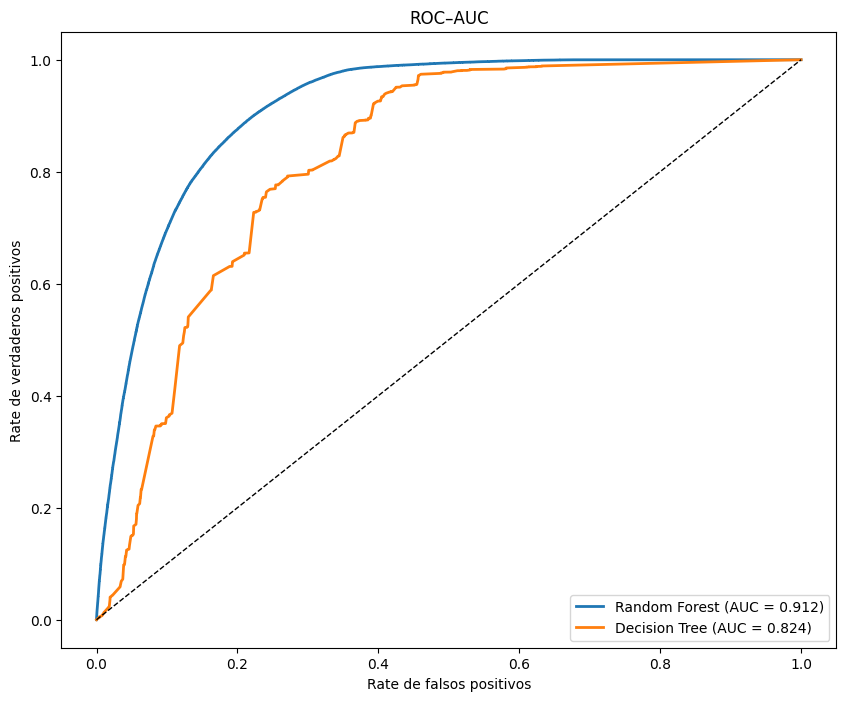

In [58]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)



plt.figure(figsize=(10, 8))

models = {
    'Random Forest': y_pred_proba_rf,
    'Decision Tree': y_pred_proba_dt,
}

for model_name, y_score in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Rate de falsos positivos')
plt.ylabel('Rate de verdaderos positivos')
plt.title('ROC–AUC')
plt.legend(loc='lower right')
plt.show()